In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from PIL import Image

print(tf.__version__)


1.12.0


## Load processed images

In [48]:
def find_matching_ylabel(filename, ytable):
    '''
    Returns the corresponding AP coordinate
    
    Inputs:
    - filename: the name of the image file *.tif
    - ytable: the AP coords in the form of a pd table
    
    Returns: the AP coordinate, None if no match
    '''
    for id, label_name in enumerate(ytable.Image):
        #print(id, label_name)
        if filename.startswith(label_name + '_'):
            return ytable.AP[id]
    
    print('Warning: no match')
    return None

In [79]:
def shuffle_datasets(X, y):
    '''Shuffle the datasets'''
    order = np.random.permutation(len(y))
    return X[order], y[order]
    
def load_dataset(folder, ylabel_file, num_training, num_validation, num_test):
    '''
    Loads a dataset
    
    Inputs:
    - filename: name of the file
    - ylabel_file: name of the ground truth label file
    
    Outputs:
    Xtrain, ytrain, Xval, yval, Xtest, ytest
    '''
    # Now load the labels
    y_table = pd.read_csv(ylabel_file)
    
    # Load the images in the folder
    files = glob.glob(folder)
    imlst = []
    y_train = []
    
    for file in files:
        filename = file.split('\\')[-1]
        im = Image.open(file)
        imlst.append(np.array(im))
        
        # Find the corresponding AP
        APval = find_matching_ylabel(filename, y_table)
        y_train.append(APval)
        #print(filename, APval)
        
    y_train = np.array(y_train)
    print(np.array(imlst).shape)
    X_train = np.array(imlst)[:,:,:,np.newaxis] # Dimension N x W x H x 1 (1 channel)
    assert len(y_train) == X_train.shape[0], "Training and labels mismatch in length"
    
    # Shuffle!
    X_train, y_train = shuffle_datasets(X_train, y_train)

    # Training and validation set
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    X_test = X_train[mask]
    y_test = y_train[mask]
    
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [80]:
def load_dataset_multiple(folder_lst, ylabel_lst, num_training, num_validation, num_test):
    '''
    Load from multiple folders
    
    Inputs:
    - folder_lst: list of folders
    - ylabel_lst: list of ylabel files
    - num_training: list or array of number of training in each file
    - num_validation: list of number of validation examples in each file
    - num_test: list of number of test examples in each file
    
    Returns: 
    Xtrain, ytrain, Xval, yval, Xtest, ytest
    '''
    X_train_all, y_train_all, X_val_all, y_val_all, X_test_all, y_test_all = [], [], [], [], [], []
    for folder, ylabel_file, ntrain, nval, ntest in zip(folder_lst, \
                                    ylabel_lst, num_training, num_validation, num_test):
        X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(folder, \
                                            ylabel_file, ntrain, nval, ntest)
        print(y_train)
        X_train_all.append(X_train)
        y_train_all.append(y_train)
        X_val_all.append(X_val)
        y_val_all.append(y_val)
        X_test_all.append(X_test)
        y_test_all.append(y_test)
        
    # Concatenate and shuffle again
    X_train_all = np.concatenate(X_train_all)
    y_train_all = np.concatenate(y_train_all)
    X_val_all = np.concatenate(X_val_all)
    y_val_all = np.concatenate(y_val_all)
    X_test_all = np.concatenate(X_test_all)
    y_test_all = np.concatenate(y_test_all)
    
    X_train_all, y_train_all = shuffle_datasets(X_train_all, y_train_all)
    X_val_all, y_val_all = shuffle_datasets(X_val_all, y_val_all)
    X_test_all, y_test_all = shuffle_datasets(X_test_all, y_test_all)
    
    return X_train_all, y_train_all, X_val_all, y_val_all, \
            X_test_all, y_test_all

In [81]:
folder_lst = ['C:\\Users\\Sur lab\\Documents\\allenCCF\\C07_small\\*.png', \
             'C:\\Users\\Sur lab\\Documents\\allenCCF\\C20_small\\*.tif']
ylabel_lst = ['human_label_APcoords.csv', 'human_label_APcoords_C20.csv']
num_training = [40, 28]
num_validation = [6, 6]
num_test = [5, 4]

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset_multiple(folder_lst, \
                                    ylabel_lst, num_training, num_validation, num_test)


(51, 80, 100)
[ 0.1  -0.1  -2.8  -2.7  -0.8  -0.4   2.4  -2.2  -2.9  -0.3   1.6  -2.9
  2.    0.5  -2.6   0.25  1.7  -2.8   0.2   0.4   1.8  -3.1  -2.5   1.9
  1.3  -2.5  -0.9  -0.5   0.6   2.2  -2.7  -2.1   2.3  -2.3   1.    0.05
 -3.   -2.4   1.4  -0.6 ]
(38, 80, 100)
[-3.5 -4.1 -2.8  0.4 -2.4 -3.7 -2.7 -3.1  2.1  0.8  1.1  1.7 -1.  -2.2
 -2.9 -0.5 -2.1 -2.5  1.  -1.2 -0.8 -1.6  2.3  0.   0.1  1.9 -0.2 -1.9]


-0.3


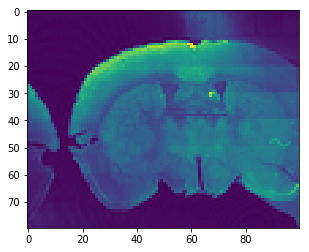

In [82]:
id = 0
plt.imshow(X_val[id,:,:,0])
print(y_val[id])

## Run NN model 

In [86]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        Construct a Dataset object to iterate over data X and labels y
        
        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_train, y_train, batch_size=5, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=5, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=5)

In [87]:
# We can iterate through a dataset like this:
for t, (x, y) in enumerate(train_dset):
    print(t, x.shape, y.shape)
    if t > 5: break

0 (5, 80, 100, 1) (5,)
1 (5, 80, 100, 1) (5,)
2 (5, 80, 100, 1) (5,)
3 (5, 80, 100, 1) (5,)
4 (5, 80, 100, 1) (5,)
5 (5, 80, 100, 1) (5,)
6 (5, 80, 100, 1) (5,)


In [90]:
# Set up some global variables
USE_GPU = False

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /cpu:0


In [105]:
X_train.shape

(68, 80, 100, 1)

In [106]:
def train_part34(model_init_fn, optimizer_init_fn, num_epochs=1):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.
    
    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train: model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for
    
    Returns: Nothing, but prints progress during trainingn
    """
    tf.reset_default_graph()    
    with tf.device(device):
        # Construct the computational graph we will use to train the model. We
        # use the model_init_fn to construct the model, declare placeholders for
        # the data and labels
        x = tf.placeholder(tf.float32, [None, 80, 100, 1])
        y = tf.placeholder(tf.int32, [None])
        
        # We need a place holder to explicitly specify if the model is in the training
        # phase or not. This is because a number of layers behaves differently in
        # training and in testing, e.g., dropout and batch normalization.
        # We pass this variable to the computation graph through feed_dict as shown below.
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        # Use the model function to build the forward pass.
        scores = model_init_fn(x, is_training)

        # Compute the loss like we did in Part II
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        loss = tf.reduce_mean(loss)

        # Use the optimizer_fn to construct an Optimizer, then use the optimizer
        # to set up the training step. Asking TensorFlow to evaluate the
        # train_op returned by optimizer.minimize(loss) will cause us to make a
        # single update step using the current minibatch of data.
        
        # Note that we use tf.control_dependencies to force the model to run
        # the tf.GraphKeys.UPDATE_OPS at each training step. tf.GraphKeys.UPDATE_OPS
        # holds the operators that update the states of the network.
        # For example, the tf.layers.batch_normalization function adds the running mean
        # and variance update operators to tf.GraphKeys.UPDATE_OPS.
        optimizer = optimizer_init_fn()
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss)

    # Now we can run the computational graph many times to train the model.
    # When we call sess.run we ask it to evaluate train_op, which causes the
    # model to update.
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        t = 0
        for epoch in range(num_epochs):
            print('Starting epoch %d' % epoch)
            for x_np, y_np in train_dset:
                feed_dict = {x: x_np, y: y_np, is_training:1}
                loss_np, _ = sess.run([loss, train_op], feed_dict=feed_dict)
                if t % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (t, loss_np))
                    check_accuracy(sess, val_dset, x, scores, is_training=is_training)
                    print()
                t += 1

In [107]:
class TwoLayerFC(tf.keras.Model):
    def __init__(self, hidden_size, num_classes):
        super().__init__()        
        initializer = tf.variance_scaling_initializer(scale=2.0)
        self.fc1 = tf.layers.Dense(hidden_size, activation=tf.nn.relu,
                                   kernel_initializer=initializer)
        self.fc2 = tf.layers.Dense(num_classes,
                                   kernel_initializer=initializer)
    def call(self, x, training=None):
        x = tf.layers.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [108]:
def check_accuracy(sess, dset, x, scores, is_training=None):
    """
    Check accuracy on a classification model.
    
    Inputs:
    - sess: A TensorFlow Session that will be used to run the graph
    - dset: A Dataset object on which to check accuracy
    - x: A TensorFlow placeholder Tensor where input images should be fed
    - scores: A TensorFlow Tensor representing the scores output from the
      model; this is the Tensor we will ask TensorFlow to evaluate.
      
    Returns: Nothing, but prints the accuracy of the model
    """
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

In [109]:
learning_rate = 1e-2

def model_init_fn(inputs, is_training):
    input_shape = (80, 100, 1)
    hidden_layer_size, num_classes = 2000, 1
    initializer = tf.variance_scaling_initializer(scale=2.0)
    layers = [
        tf.layers.Flatten(input_shape=input_shape),
        #tf.layers.Dense(hidden_layer_size, activation=tf.nn.relu,
        #                kernel_initializer=initializer),
        tf.layers.Dense(num_classes, kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    return model(inputs)

def optimizer_init_fn():
    return tf.train.GradientDescentOptimizer(learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Starting epoch 0


InvalidArgumentError: Received a label value of -2 which is outside the valid range of [0, 1).  Label values: 2 -2 -2 -2 0
	 [[node SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-106-2c92aa131c5f>:35)  = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](sequential/dense_1/BiasAdd, _arg_Placeholder_1_0_1)]]

Caused by op 'SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits', defined at:
  File "C:\Anaconda3\envs\tflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Anaconda3\envs\tflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Anaconda3\envs\tflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Anaconda3\envs\tflow\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Anaconda3\envs\tflow\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Anaconda3\envs\tflow\lib\asyncio\base_events.py", line 427, in run_forever
    self._run_once()
  File "C:\Anaconda3\envs\tflow\lib\asyncio\base_events.py", line 1440, in _run_once
    handle._run()
  File "C:\Anaconda3\envs\tflow\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Anaconda3\envs\tflow\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Anaconda3\envs\tflow\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Anaconda3\envs\tflow\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Anaconda3\envs\tflow\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Anaconda3\envs\tflow\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Anaconda3\envs\tflow\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-109-035173cfb63b>", line 19, in <module>
    train_part34(model_init_fn, optimizer_init_fn)
  File "<ipython-input-106-2c92aa131c5f>", line 35, in train_part34
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 2049, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 8063, in sparse_softmax_cross_entropy_with_logits
    labels=labels, name=name)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Anaconda3\envs\tflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Received a label value of -2 which is outside the valid range of [0, 1).  Label values: 2 -2 -2 -2 0
	 [[node SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-106-2c92aa131c5f>:35)  = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](sequential/dense_1/BiasAdd, _arg_Placeholder_1_0_1)]]


## Resize and process raw images

In [33]:
#folder = 'C:\\Users\\Sur lab\\Documents\\allenCCF3\\Data\\MouseC07'
folder = 'C:\\Users\\Sur lab\\Dropbox (MIT)\\Leica\\C07_LMN_092018_disynaptic_STRACC_mCherry_10x'
folder2 = 'C:\\Users\\Sur lab\Dropbox (MIT)\\Leica\\C20_LMN_CAVCreRACC_RabiesLACC_112618'
#folder = 'C:\\Users\\Sur lab\\Documents\\allenCCF3\\Data\\MouseC07\\Raw'
files = glob.glob(folder + '\\*\\*ch00.tif')
files2 = glob.glob(folder2 + '\\*ch00.tif')

In [34]:
order = np.array([0, 2, 4, 6, 8, 10, 1, 3, 5, 7, 9, 11,
                 12, 14, 16, 18, 20, 13, 15, 17, 19, 21,
                 22, 24, 26, 28, 30, 32, 23, 25, 27, 29, 31, 33,
                 34, 38, 42, 46, 50, 51, 52, 53,
                 35, 36, 37, 39, 40, 41, 43, 44, 45, 47, 48, 49, 55, 56])

In [41]:
# Load images
bad_images = [38, 40, 44, 48, 52, 55, 59, 60, 61, 62]
flipped_images = [26, 36, 37, 41, 42, 45, 46, 49, 50, 56, 57]
#all_images = np.zeros((51 * 120, 80, 100, 1))
naugment = 50
imshape = (100, 80)
crop_extent = 10

count = 0
imlst = []
for i in range(len(order)):
    #print(im.height/40, im.width/40, i)
    if order[i] + 1 in bad_images:
        continue
    
    im = Image.open(files[order[i]])
    imresize = im.resize(imshape, Image.ANTIALIAS)
    
    if order[i] + 1 in flipped_images:
        imresize = imresize.transpose(Image.FLIP_TOP_BOTTOM)
        
    # Save image
    imresize.save('C07_small/C07_im' + str(i) + '_small.png')

In [ ]:
imresize = im.resize(imshape, Image.ANTIALIAS)
    #imarr = np.array(imresize)
    if order[i] + 1 in flipped_images:
        imresize = imresize.transpose(Image.FLIP_TOP_BOTTOM)
        
    # Save image
    imresize.save('C07_small/C07_im' + str(i) + '.png')
        
    # Data augmentation
    for i in range(naugment):
        # Pick a random angle
        angle = np.random.rand() * crop_extent * 2 - crop_extent
        ver_crop = np.random.rand() * crop_extent * 2 - crop_extent
        hor_crop = np.random.rand() * crop_extent * 2 - crop_extent
        
        modified1 = imresize.rotate(angle).crop((ver_crop, hor_crop, ver_crop+imshape[0], hor_crop+imshape[1]))
        modified2 = modified1.transpose(Image.FLIP_LEFT_RIGHT)
        
        modified1 = np.array(modified1)[:,:,np.newaxis] / 256
        modified2 = np.array(modified2)[:,:,np.newaxis] / 256
        
        imlst += [modified1, modified2]
   
    

In [43]:
# Load C20 images
naugment = 50
imshape = (100, 80)
crop_extent = 10

count = 0
imlst = []
for i in range(len(files2)):
    print(i)
    
    im = Image.open(files2[i])
    imsave = im.resize(imshape, Image.ANTIALIAS)
    imresize = im.resize(imshape, Image.ANTIALIAS)
    #imarr = np.array(imresize)
    #if order[i] + 1 in flipped_images:
    #    imresize = imresize.transpose(Image.FLIP_TOP_BOTTOM)
        
    # Save image
    imsave.save('C20_small/C20_im' + str(i) + '_small.tif')
    
    imarr = np.array(imresize)[:,:,np.newaxis] / 256
    imlst.append(imarr)
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


In [ ]:
    # Data augmentation
    for i in range(naugment):
        # Pick a random angle
        angle = np.random.rand() * crop_extent * 2 - crop_extent
        ver_crop = np.random.rand() * crop_extent * 2 - crop_extent
        hor_crop = np.random.rand() * crop_extent * 2 - crop_extent
        
        modified1 = imresize.rotate(angle).crop((ver_crop, hor_crop, ver_crop+imshape[0], hor_crop+imshape[1]))
        modified2 = modified1.transpose(Image.FLIP_LEFT_RIGHT)
        
        modified1 = np.array(modified1)[:,:,np.newaxis] / 256
        modified2 = np.array(modified2)[:,:,np.newaxis] / 256
        
        imlst += [modified1, modified2]
        #print(modified1.shape, modified2.shape)
        
    #all_images[count] = imarr[:,:,np.newaxis] / 256
    
    #count += 1
    #plt.imshow(imarr, aspect='auto')
    #imlst.append(imarr)

In [ ]:
zcoords = pd.read_csv('human_label_APcoords.csv')
zcoords = zcoords[zcoords.AP < 100].AP
zcoords = np.array(zcoords).repeat(100)
plt.plot(zcoords)
#plt.plot(zcoords2)

In [ ]:
all_images = np.array(imlst)
plt.figure(figsize=(20,15))
for i in range(38):
    plt.subplot(9, 7, i + 1)
    plt.imshow(all_images[i,:,:,0], aspect='auto')
    
zcoords = pd.read_csv('human_label_APcoords_C20.csv')
#zcoords = np.linspace(1.98, -2.9, 51)
#zcoords = zcoords.repeat(naugment * 2)


In [ ]:
# Now randomize the array
nimages = all_images.shape[0]
ntrain = int(nimages * 0.7)
nval = int(nimages * 0.2)
ntest = nimages - ntrain - nval

order = np.arange(nimages)
np.random.shuffle(order)

shuffled_images = all_images[order]
shuffled_coords = zcoords[order]

train_images = shuffled_images[:ntrain]
train_coords = shuffled_coords[:ntrain]
val_images = shuffled_images[ntrain:(ntrain + nval)]
val_coords = shuffled_coords[ntrain:(ntrain + nval)]
test_images = shuffled_images[ntrain+nval:]
test_coords = shuffled_coords[ntrain+nval:]

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(5,5), strides=(1,1),
                            activation='relu', input_shape=(imshape[1],imshape[0],1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(keras.layers.Conv2D(64, (5, 5), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1))

In [ ]:
sgd = keras.optimizers.SGD(lr=0.1, clipnorm=1.)
adagrad = tf.train.AdagradOptimizer(learning_rate=10)
adam = tf.train.AdadeltaOptimizer(learning_rate=30)
model.compile(optimizer= adam, 
              loss='mean_squared_error')

model.fit(train_images, train_coords, epochs=1000)

In [ ]:
# To save trained model
model.save('brain_slice_model_Adeltagrad.h5')

In [ ]:
val_images[0].shape

In [ ]:
id = 3
plt.imshow(val_images[id][:,:,0])
print('Coords = ', val_coords[id], ', predicted = ', prediction_val[id])

In [ ]:
prediction_test = model.predict(all_images)

In [ ]:
all_images.shape

In [ ]:
plt.scatter(prediction_test, zcoords.AP)

In [ ]:
prediction_test.shape

In [ ]:
zcoords.shape

In [ ]:
prediction = model.predict(train_images)


plt.scatter(train_coords, prediction)

#prediction_val = model.predict(val_images)
#plt.scatter(val_coords, prediction_val, alpha=0.5)

plt.plot([-3, 3], [-3, 3])

err = prediction_val.flatten() - val_coords
print('RMS error is', np.sqrt(np.mean(err**2)))

## Implementing Keras sequential API

In [ ]:
def load_cifar10(num_training=49000, num_validation=1000, num_test=10000):
    """
    Fetch the CIFAR-10 dataset from the web and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

In [ ]:
# Set up some global variables
USE_GPU = False

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

In [ ]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        Construct a Dataset object to iterate over data X and labels y
        
        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=64)

In [ ]:
learning_rate = 1e-2

def model_init_fn(inputs, is_training):
    input_shape = (32, 32, 3)
    hidden_layer_size, num_classes = 4000, 10
    initializer = tf.variance_scaling_initializer(scale=2.0)
    layers = [
        tf.layers.Flatten(input_shape=input_shape),
        tf.layers.Dense(hidden_layer_size, activation=tf.nn.relu,
                        kernel_initializer=initializer),
        tf.layers.Dense(num_classes, kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    return model(inputs)

def optimizer_init_fn():
    return tf.train.GradientDescentOptimizer(learning_rate)

train_part34(model_init_fn, optimizer_init_fn)